In [1]:
# Create a GNN dataset with k-NNGraphs with Torch Geometric
from dataset import *
import matplotlib.pyplot as plt
import torch


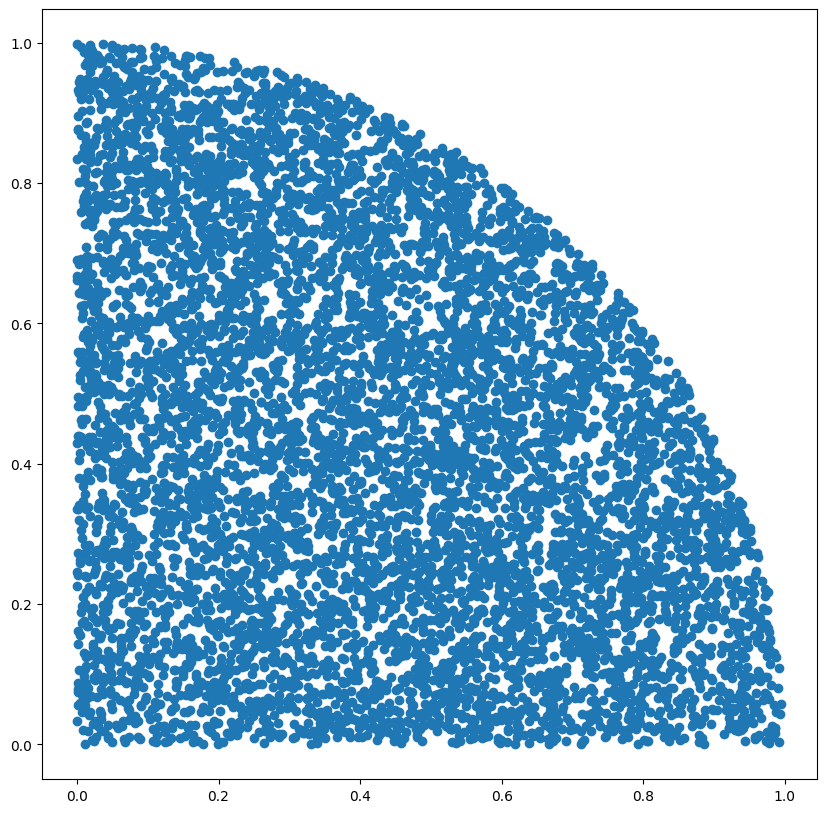

In [2]:
test = get_ellipse_coords_uniform(10000,1,1)
plt.figure(figsize=(10,10))
plt.scatter(test[:,0],test[:,1])
plt.show()

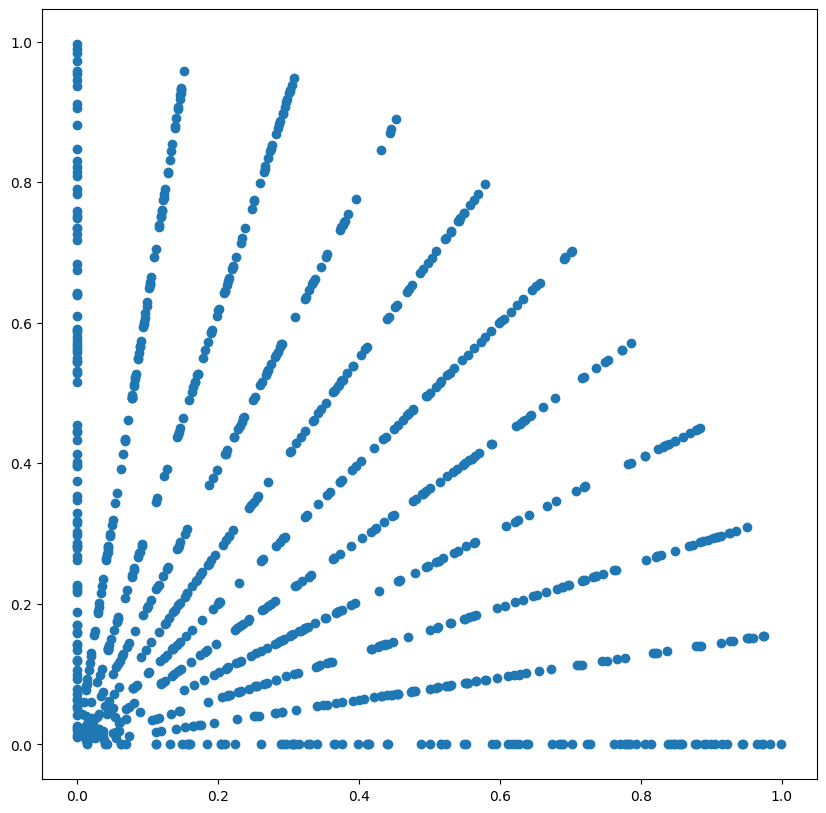

In [3]:
density = 100
test = get_multiple_circles(density, a, (7,7), 2, cartesian = False)
plt.figure(figsize=(10,10))
plt.scatter(test[:,0],test[:,1])
plt.show()

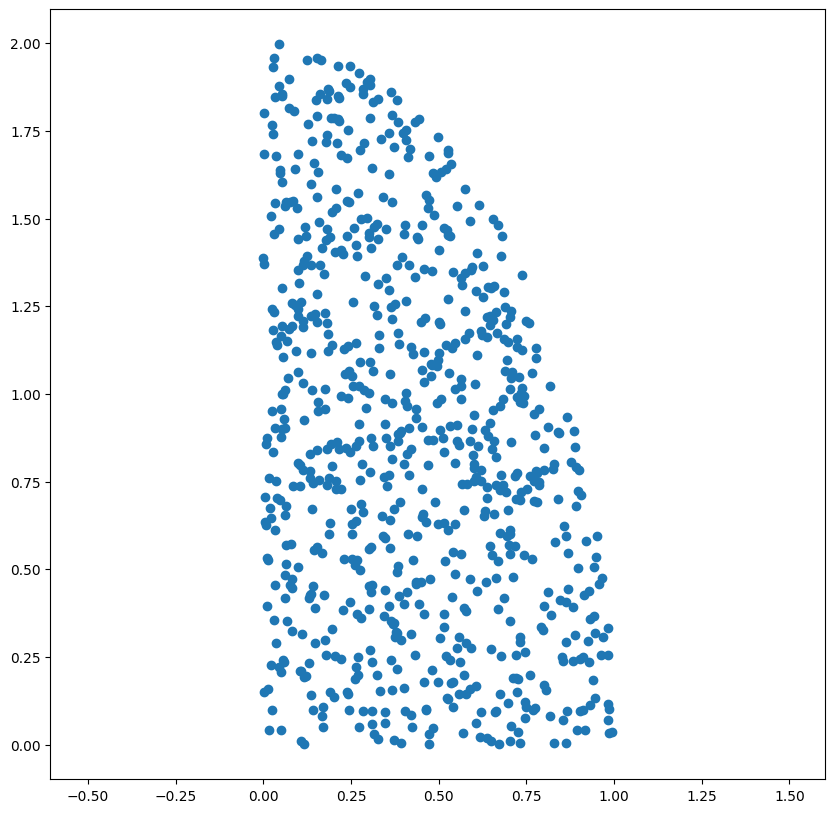

In [4]:
test = get_ellipse_coords_uniform(1000,1,2)
plt.figure(figsize=(10,10))
plt.scatter(test[:,0],test[:,1])
plt.axis('equal')
plt.show()

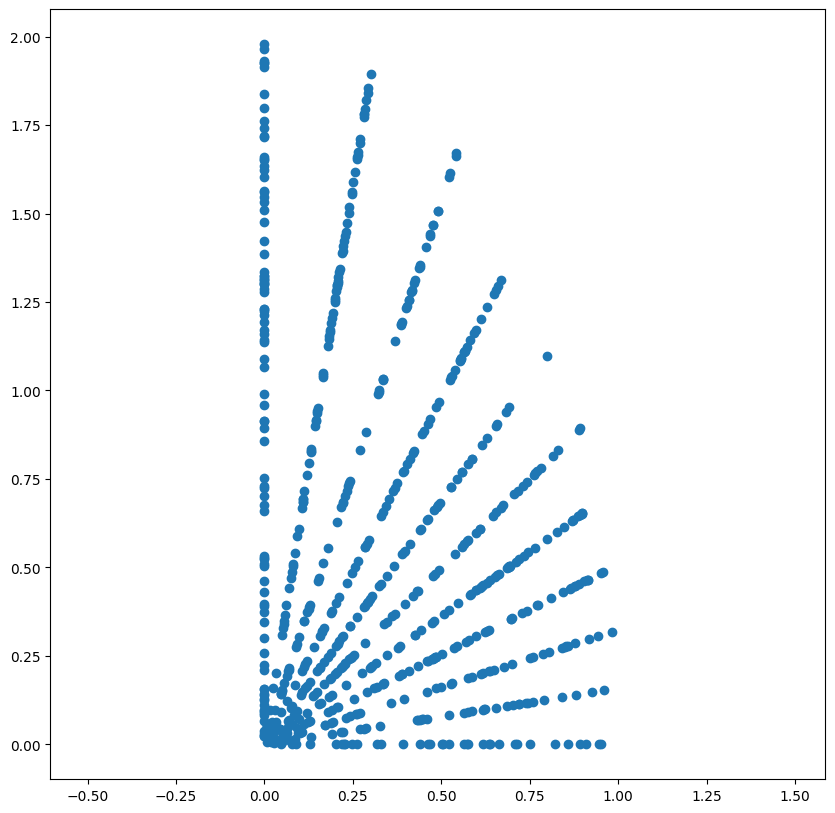

In [5]:
test = get_ellipse_coords_radial(1000,1,2)
plt.figure(figsize=(10,10))
plt.scatter(test[:,0],test[:,1])
plt.axis('equal')
plt.show()

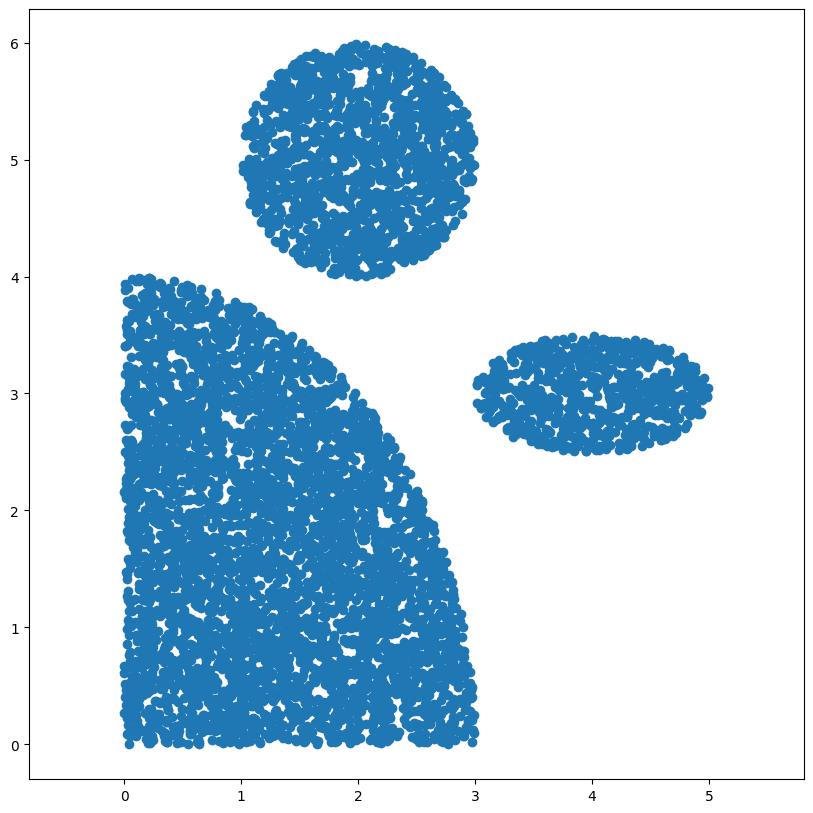

In [6]:
test = get_multiple_ellipses(50000, a = 3, b = 4, x1 = 4, y1 = 3, a1 = 1, b1 = 0.5, x2 = 2, y2 = 5, a2 = 1, b2 = 1)
plt.figure(figsize=(10,10))
plt.scatter(test[:,0],test[:,1])
plt.axis('equal')
plt.show()

True area=  75.39822368615503
Number mask 1: 1976  mask 2:  1670
Computed area =  66.37727393085721


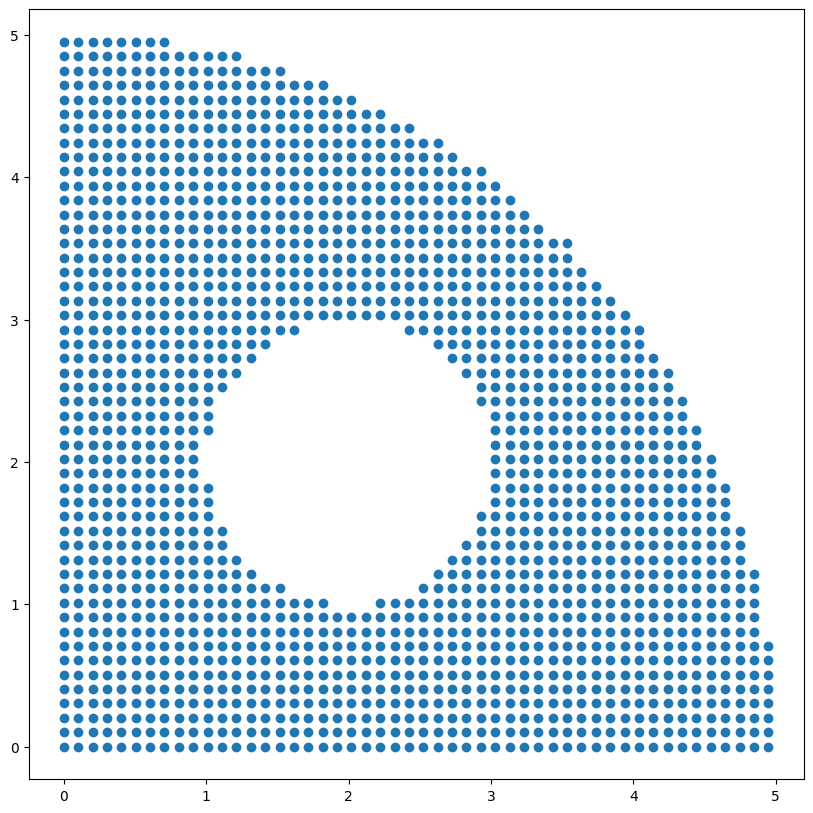

66.6157551545609


In [2]:
test = get_truncated_ellipses(10000, a = 5, b = 5, x1 = 2, y1 = 2, a1 = 1, b1 = 1)
plt.figure(figsize=(10,10))
plt.scatter(test[:,0],test[:,1])
plt.axis('equal')
plt.show()
print(np.pi*25/1976*1676)

(100, 2)


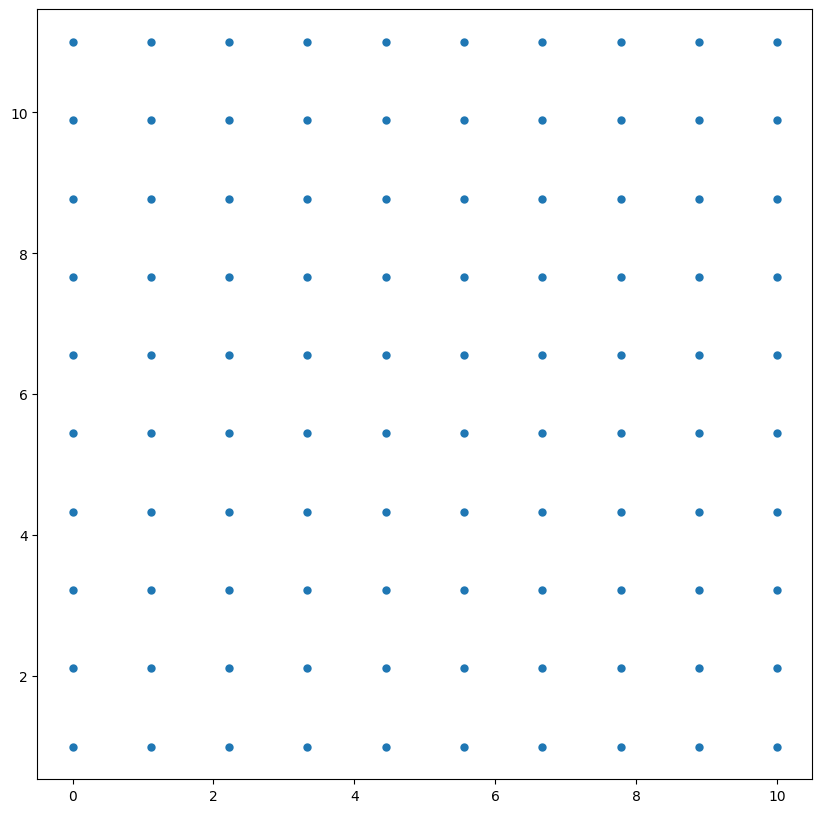

In [6]:
x = np.linspace(0, 10, 10)
y = np.linspace(1, 10, 10)
xx, yy = np.meshgrid(x,y, sparse=False)
test = np.column_stack((xx.flatten(),yy.flatten()))
test.shape
print(np.shape(test))
plt.figure(figsize=(10,10))
plt.scatter(xx,yy, linewidths= 0.01)
plt.axis('equal')
plt.show()

In [2]:
# Dataset parameters
n_samples  = 500000
n_points   = 1000
min_radius = 1
max_radius = 10

# percentage of the dataset used for training and testing
train_size = round(0.8*n_samples)
test_size  = n_samples - train_size


dataset = EllipsesDataset(root='Data')
dataset = dataset.shuffle()
train_dataset = dataset[:train_size]
test_dataset = dataset[test_size:]

In [3]:
dataset.data.y


tensor([119.2698, 150.7217,  22.6623,  ...,  29.3913,  79.8466,  12.3969])

In [4]:
# Getting some insights about the first graph
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(data.y)



Dataset: EllipsesDataset(12500):
Number of graphs: 12500
Number of features: 2
Number of classes: 12500

Data(x=[212, 2], edge_index=[2, 2120], y=[1])
Number of nodes: 212
Number of edges: 2120
Average node degree: 10.00
Has isolated nodes: False
Has self-loops: True
Is undirected: False
tensor([132.4187])


In [3]:
from torch_geometric.loader import DataLoader
batch_size= 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = True)

/Users/tabtab/.pyenv/versions/3.10.1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'train_dataset' is not defined

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin   = Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # 1. Obtain node embeddings 
        x = self.conv1(x.float(), edge_index)
        x = x.relu()
        x = self.conv2(x.float(), edge_index)
        x = x.relu()
        x = self.conv3(x.float(), edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)
        
        return x
    
    def loss(self, pred, score):
        # Start with MAE loss function, then switch to MSE when the error falls below delta
        return F.huber_loss(pred, score, reduction = 'mean', delta = 0.1) # ATTENTION delta dépend des labels 0.1 --> rmax =1 


model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(2, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [ ]:
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, eps = 1e-7)
reduce_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, factor=0.2, patience=5, min_lr=1e-7, verbose = True)
early_stopping = EarlyStopping(patience=20)
criterion = model.loss
# Create a writer in folder "History"
writer = SummaryWriter("History/TensorBoard")


In [ ]:
def fit(model, train_loader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0.
    train_running_mae = 0.
    train_running_mse = 0.
    counter = 0
    prog_bar = tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size))
    
    for data in prog_bar:  # Iterate in batches over the training dataset.
        counter += 1
        data = data[1].to(device)
        target = data.y.float()
        # zero the parameter gradients
        model.zero_grad()
        preds = model(data)[:,0]  # Perform a single forward pass.
        loss = criterion(preds, target)
        # update metrics 
        train_running_loss += loss.item()
        train_running_mse += F.mse_loss(preds,target)
        train_running_mae += F.l1_loss(preds, target)

        loss.backward()
        # Update parameters based on gradients.
        optimizer.step()  

    # compute the mean metrics over the all batch
    train_loss = train_running_loss / counter
    train_mse = train_running_mse/counter
    train_mae = train_running_mae/counter

    return train_loss, train_mse, train_mae

In [ ]:
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.
    val_running_correct = 0.
    val_running_mae = 0.
    val_running_mse = 0.
    counter = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data = data.to(device)
            target = data.y.float()
            preds = model(data)[:,0]
            loss = criterion(preds, target)
            # update metrics
            val_running_loss += loss.item()
            val_running_mse += F.mse_loss(preds,target)
            val_running_mae += F.l1_loss(preds, target)
    
    # Compute the mean of metrics over the all batch
    val_loss = val_running_loss / counter
    val_mse = val_running_mse/counter
    val_mae = val_running_mae/counter

    return val_loss, val_mse, val_mae

In [ ]:
def checkpoint(epoch, loss):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'History/checkpoint.pt')
def history(epoch, train_loss, test_loss, train_mse, test_mse, train_mae, test_mae):
    torch.save({
            'epoch': epoch,
            'optimizer_state_dict': optimizer.state_dict(),
            # we don't save model weights and biases every epochs to save memory 
            'Train_Huber_loss': train_loss,
            'Test_Huber_loss': test_loss,
            'Train_MSE': train_mse,
            'Test_MSE': test_mse,
            'Train_MAE': train_mae,
            'Test_MSE': test_mse,
            }, 'History/history.pt')

In [ ]:
# Training loop
import time

start = time.time()
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_mse, train_epoch_mae = fit(
        model, train_loader, train_dataset, optimizer, criterion
    )
    val_epoch_loss, val_epoch_mse, val_epoch_mae = validate(
        model, test_loader, test_dataset, criterion
    )
    # Add loss results to SummaryWriter
    writer.add_scalars(main_tag="Huber_Loss", 
                           tag_scalar_dict={"train_loss": train_epoch_loss,
                                            "test_loss": val_epoch_loss},
                           global_step=epoch)

    # add MSE to Summary Writer
    writer.add_scalars(main_tag="MSE", 
                           tag_scalar_dict={"train_MSE": train_epoch_mse,
                                            "test_MSE": val_epoch_mse},
                           global_step=epoch) 
    writer.add_scalars(main_tag="MAE", 
                           tag_scalar_dict={"train_MAE": train_epoch_mae,
                                            "test_MAE": val_epoch_mae},
                           global_step=epoch)        
    
    # update EarlyStopping class
    early_stopping(val_epoch_loss)
    if early_stopping.counter == 0:
    # save a checkpoint if the validation loss has improved for this epoch
        checkpoint(epoch, val_epoch_loss)
    if early_stopping.early_stop:
        break
    # save an history 
    print(f"Train Loss: {train_epoch_loss:.4f}, Train MAE: {train_epoch_mae:.2f}")
    print(f'Test Loss: {val_epoch_loss:.4f}, Test MAE: {val_epoch_mae:.2f}')

end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch 1 of 100
Training


7it [00:04,  1.48it/s]                       


Validating


7it [00:01,  3.76it/s]                       


Train Loss: 0.2839, Train MAE: 2.89
Test Loss: 0.2665, Test MAE: 2.71
Epoch 2 of 100
Training


7it [00:04,  1.46it/s]                       


Validating


7it [00:02,  3.18it/s]                       


Train Loss: 0.2476, Train MAE: 2.53
Test Loss: 0.2176, Test MAE: 2.23
Epoch 3 of 100
Training


7it [00:04,  1.61it/s]                       


Validating


7it [00:01,  3.58it/s]                       


Train Loss: 0.1856, Train MAE: 1.91
Test Loss: 0.1367, Test MAE: 1.42
Epoch 4 of 100
Training


7it [00:04,  1.67it/s]                       


Validating


7it [00:01,  3.71it/s]                       


Train Loss: 0.0850, Train MAE: 0.90
Test Loss: 0.0181, Test MAE: 0.23
Epoch 5 of 100
Training


7it [00:04,  1.69it/s]                       


Validating


7it [00:01,  3.59it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0411, Train MAE: 0.46
Test Loss: 0.0466, Test MAE: 0.52
Epoch 6 of 100
Training


7it [00:04,  1.64it/s]                       


Validating


7it [00:01,  3.74it/s]                       


INFO: Early stopping counter 2 of 20
Train Loss: 0.0287, Train MAE: 0.33
Test Loss: 0.0235, Test MAE: 0.28
Epoch 7 of 100
Training


7it [00:04,  1.44it/s]                       


Validating


7it [00:01,  3.63it/s]                       


INFO: Early stopping counter 3 of 20
Train Loss: 0.0290, Train MAE: 0.34
Test Loss: 0.0230, Test MAE: 0.28
Epoch 8 of 100
Training


7it [00:04,  1.50it/s]                       


Validating


7it [00:01,  3.54it/s]                       


INFO: Early stopping counter 4 of 20
Train Loss: 0.0216, Train MAE: 0.26
Test Loss: 0.0195, Test MAE: 0.24
Epoch 9 of 100
Training


7it [00:04,  1.73it/s]                       


Validating


7it [00:02,  3.44it/s]                       


Train Loss: 0.0226, Train MAE: 0.27
Test Loss: 0.0174, Test MAE: 0.22
Epoch 10 of 100
Training


7it [00:04,  1.66it/s]                       


Validating


7it [00:01,  3.88it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0209, Train MAE: 0.26
Test Loss: 0.0187, Test MAE: 0.23
Epoch 11 of 100
Training


7it [00:04,  1.60it/s]                       


Validating


7it [00:01,  3.66it/s]                       


Train Loss: 0.0201, Train MAE: 0.25
Test Loss: 0.0166, Test MAE: 0.21
Epoch 12 of 100
Training


7it [00:04,  1.73it/s]                       


Validating


7it [00:01,  3.54it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0202, Train MAE: 0.25
Test Loss: 0.0170, Test MAE: 0.22
Epoch 13 of 100
Training


7it [00:04,  1.61it/s]                       


Validating


7it [00:02,  3.19it/s]                       


INFO: Early stopping counter 2 of 20
Train Loss: 0.0196, Train MAE: 0.24
Test Loss: 0.0171, Test MAE: 0.22
Epoch 14 of 100
Training


7it [00:04,  1.57it/s]                       


Validating


7it [00:01,  3.88it/s]                       


INFO: Early stopping counter 3 of 20
Train Loss: 0.0193, Train MAE: 0.24
Test Loss: 0.0169, Test MAE: 0.22
Epoch 15 of 100
Training


7it [00:04,  1.62it/s]                       


Validating


7it [00:01,  3.80it/s]                       


INFO: Early stopping counter 4 of 20
Train Loss: 0.0192, Train MAE: 0.24
Test Loss: 0.0167, Test MAE: 0.21
Epoch 16 of 100
Training


7it [00:04,  1.70it/s]                       


Validating


7it [00:01,  3.94it/s]                       


INFO: Early stopping counter 5 of 20
Train Loss: 0.0193, Train MAE: 0.24
Test Loss: 0.0175, Test MAE: 0.22
Epoch 17 of 100
Training


7it [00:04,  1.59it/s]                       


Validating


7it [00:02,  3.43it/s]                       


INFO: Early stopping counter 6 of 20
Train Loss: 0.0200, Train MAE: 0.25
Test Loss: 0.0169, Test MAE: 0.22
Epoch 18 of 100
Training


7it [00:04,  1.51it/s]                       


Validating


7it [00:01,  3.69it/s]                       


Train Loss: 0.0191, Train MAE: 0.24
Test Loss: 0.0166, Test MAE: 0.21
Epoch 19 of 100
Training


7it [00:04,  1.68it/s]                       


Validating


7it [00:01,  3.99it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0201, Train MAE: 0.25
Test Loss: 0.0166, Test MAE: 0.21
Epoch 20 of 100
Training


7it [00:03,  1.76it/s]                       


Validating


7it [00:02,  3.00it/s]                       


INFO: Early stopping counter 2 of 20
Train Loss: 0.0192, Train MAE: 0.24
Test Loss: 0.0166, Test MAE: 0.21
Epoch 21 of 100
Training


7it [00:04,  1.53it/s]                       


Validating


7it [00:02,  3.24it/s]                       


Train Loss: 0.0194, Train MAE: 0.24
Test Loss: 0.0164, Test MAE: 0.21
Epoch 22 of 100
Training


7it [00:04,  1.57it/s]                       


Validating


7it [00:02,  3.30it/s]                       


Train Loss: 0.0192, Train MAE: 0.24
Test Loss: 0.0160, Test MAE: 0.21
Epoch 23 of 100
Training


7it [00:04,  1.65it/s]                       


Validating


7it [00:01,  3.82it/s]                       


Train Loss: 0.0191, Train MAE: 0.24
Test Loss: 0.0160, Test MAE: 0.21
Epoch 24 of 100
Training


7it [00:04,  1.66it/s]                       


Validating


7it [00:02,  2.99it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0187, Train MAE: 0.23
Test Loss: 0.0161, Test MAE: 0.21
Epoch 25 of 100
Training


7it [00:04,  1.54it/s]                       


Validating


7it [00:02,  3.46it/s]                       


INFO: Early stopping counter 2 of 20
Train Loss: 0.0191, Train MAE: 0.24
Test Loss: 0.0163, Test MAE: 0.21
Epoch 26 of 100
Training


7it [00:04,  1.50it/s]                       


Validating


7it [00:02,  3.02it/s]                       


Train Loss: 0.0194, Train MAE: 0.24
Test Loss: 0.0156, Test MAE: 0.20
Epoch 27 of 100
Training


7it [00:04,  1.49it/s]                       


Validating


7it [00:02,  3.25it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0190, Train MAE: 0.24
Test Loss: 0.0161, Test MAE: 0.21
Epoch 28 of 100
Training


7it [00:05,  1.38it/s]                       


Validating


7it [00:02,  3.29it/s]                       


Train Loss: 0.0191, Train MAE: 0.24
Test Loss: 0.0156, Test MAE: 0.20
Epoch 29 of 100
Training


7it [00:04,  1.65it/s]                       


Validating


7it [00:01,  3.78it/s]                       


Train Loss: 0.0185, Train MAE: 0.23
Test Loss: 0.0152, Test MAE: 0.20
Epoch 30 of 100
Training


7it [00:04,  1.70it/s]                       


Validating


7it [00:01,  3.60it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0175, Train MAE: 0.22
Test Loss: 0.0157, Test MAE: 0.20
Epoch 31 of 100
Training


7it [00:04,  1.71it/s]                       


Validating


7it [00:01,  3.98it/s]                       


Train Loss: 0.0187, Train MAE: 0.23
Test Loss: 0.0150, Test MAE: 0.20
Epoch 32 of 100
Training


7it [00:04,  1.60it/s]                       


Validating


7it [00:01,  3.96it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0192, Train MAE: 0.24
Test Loss: 0.0151, Test MAE: 0.20
Epoch 33 of 100
Training


7it [00:04,  1.64it/s]                       


Validating


7it [00:01,  3.74it/s]                       


Train Loss: 0.0178, Train MAE: 0.22
Test Loss: 0.0149, Test MAE: 0.20
Epoch 34 of 100
Training


7it [00:04,  1.65it/s]                       


Validating


7it [00:02,  3.15it/s]                       


Train Loss: 0.0186, Train MAE: 0.23
Test Loss: 0.0148, Test MAE: 0.19
Epoch 35 of 100
Training


7it [00:04,  1.62it/s]                       


Validating


7it [00:02,  3.28it/s]                       


Train Loss: 0.0180, Train MAE: 0.23
Test Loss: 0.0148, Test MAE: 0.19
Epoch 36 of 100
Training


7it [00:04,  1.65it/s]                       


Validating


7it [00:01,  3.88it/s]                       


Train Loss: 0.0182, Train MAE: 0.23
Test Loss: 0.0145, Test MAE: 0.19
Epoch 37 of 100
Training


7it [00:04,  1.53it/s]                       


Validating


7it [00:02,  2.98it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0177, Train MAE: 0.22
Test Loss: 0.0146, Test MAE: 0.19
Epoch 38 of 100
Training


7it [00:04,  1.49it/s]                       


Validating


7it [00:02,  3.30it/s]                       


Train Loss: 0.0190, Train MAE: 0.24
Test Loss: 0.0144, Test MAE: 0.19
Epoch 39 of 100
Training


7it [00:04,  1.65it/s]                       


Validating


7it [00:01,  3.67it/s]                       


Train Loss: 0.0173, Train MAE: 0.22
Test Loss: 0.0141, Test MAE: 0.19
Epoch 40 of 100
Training


7it [00:04,  1.71it/s]                       


Validating


7it [00:01,  3.75it/s]                       


Train Loss: 0.0179, Train MAE: 0.22
Test Loss: 0.0140, Test MAE: 0.19
Epoch 41 of 100
Training


7it [00:04,  1.59it/s]                       


Validating


7it [00:01,  3.97it/s]                       


Train Loss: 0.0172, Train MAE: 0.22
Test Loss: 0.0140, Test MAE: 0.19
Epoch 42 of 100
Training


7it [00:04,  1.72it/s]                       


Validating


7it [00:01,  4.00it/s]                       


Train Loss: 0.0170, Train MAE: 0.22
Test Loss: 0.0135, Test MAE: 0.18
Epoch 43 of 100
Training


7it [00:04,  1.60it/s]                       


Validating


7it [00:02,  3.45it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0173, Train MAE: 0.22
Test Loss: 0.0138, Test MAE: 0.18
Epoch 44 of 100
Training


7it [00:04,  1.41it/s]                       


Validating


7it [00:01,  3.76it/s]                       


Train Loss: 0.0175, Train MAE: 0.22
Test Loss: 0.0132, Test MAE: 0.18
Epoch 45 of 100
Training


7it [00:04,  1.57it/s]                       


Validating


7it [00:01,  3.81it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0167, Train MAE: 0.21
Test Loss: 0.0141, Test MAE: 0.19
Epoch 46 of 100
Training


7it [00:04,  1.60it/s]                       


Validating


7it [00:01,  3.65it/s]                       


INFO: Early stopping counter 2 of 20
Train Loss: 0.0169, Train MAE: 0.21
Test Loss: 0.0133, Test MAE: 0.18
Epoch 47 of 100
Training


7it [00:04,  1.59it/s]                       


Validating


7it [00:02,  3.13it/s]                       


INFO: Early stopping counter 3 of 20
Train Loss: 0.0154, Train MAE: 0.20
Test Loss: 0.0136, Test MAE: 0.18
Epoch 48 of 100
Training


7it [00:04,  1.63it/s]                       


Validating


7it [00:01,  3.61it/s]                       


Train Loss: 0.0159, Train MAE: 0.20
Test Loss: 0.0123, Test MAE: 0.17
Epoch 49 of 100
Training


7it [00:04,  1.44it/s]                       


Validating


7it [00:02,  3.27it/s]                       


Train Loss: 0.0156, Train MAE: 0.20
Test Loss: 0.0122, Test MAE: 0.17
Epoch 50 of 100
Training


7it [00:04,  1.47it/s]                       


Validating


7it [00:02,  3.50it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0161, Train MAE: 0.21
Test Loss: 0.0122, Test MAE: 0.17
Epoch 51 of 100
Training


7it [00:06,  1.07it/s]                       


Validating


7it [00:02,  3.15it/s]                       


Train Loss: 0.0153, Train MAE: 0.20
Test Loss: 0.0117, Test MAE: 0.16
Epoch 52 of 100
Training


7it [00:04,  1.69it/s]                       


Validating


7it [00:01,  4.13it/s]                       


Train Loss: 0.0144, Train MAE: 0.19
Test Loss: 0.0116, Test MAE: 0.16
Epoch 53 of 100
Training


7it [00:04,  1.64it/s]                       


Validating


7it [00:01,  4.00it/s]                       


Train Loss: 0.0155, Train MAE: 0.20
Test Loss: 0.0115, Test MAE: 0.16
Epoch 54 of 100
Training


7it [00:03,  1.76it/s]                       


Validating


7it [00:01,  3.79it/s]                       


Train Loss: 0.0150, Train MAE: 0.20
Test Loss: 0.0108, Test MAE: 0.15
Epoch 55 of 100
Training


7it [00:04,  1.61it/s]                       


Validating


7it [00:02,  3.16it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0147, Train MAE: 0.19
Test Loss: 0.0126, Test MAE: 0.17
Epoch 56 of 100
Training


7it [00:05,  1.35it/s]                       


Validating


7it [00:01,  3.72it/s]                       


INFO: Early stopping counter 2 of 20
Train Loss: 0.0147, Train MAE: 0.19
Test Loss: 0.0110, Test MAE: 0.15
Epoch 57 of 100
Training


7it [00:04,  1.72it/s]                       


Validating


7it [00:01,  3.76it/s]                       


Train Loss: 0.0157, Train MAE: 0.20
Test Loss: 0.0103, Test MAE: 0.15
Epoch 58 of 100
Training


7it [00:03,  1.76it/s]                       


Validating


7it [00:01,  4.09it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0149, Train MAE: 0.19
Test Loss: 0.0117, Test MAE: 0.16
Epoch 59 of 100
Training


7it [00:04,  1.74it/s]                       


Validating


7it [00:01,  4.08it/s]                       


Train Loss: 0.0137, Train MAE: 0.18
Test Loss: 0.0097, Test MAE: 0.14
Epoch 60 of 100
Training


7it [00:03,  1.77it/s]                       


Validating


7it [00:01,  4.09it/s]                       


Train Loss: 0.0132, Train MAE: 0.18
Test Loss: 0.0094, Test MAE: 0.14
Epoch 61 of 100
Training


7it [00:04,  1.53it/s]                       


Validating


7it [00:02,  3.22it/s]                       


Train Loss: 0.0128, Train MAE: 0.17
Test Loss: 0.0089, Test MAE: 0.13
Epoch 62 of 100
Training


7it [00:04,  1.64it/s]                       


Validating


7it [00:01,  3.55it/s]                       


Train Loss: 0.0133, Train MAE: 0.18
Test Loss: 0.0088, Test MAE: 0.13
Epoch 63 of 100
Training


7it [00:05,  1.24it/s]                       


Validating


7it [00:02,  3.31it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0121, Train MAE: 0.16
Test Loss: 0.0089, Test MAE: 0.13
Epoch 64 of 100
Training


7it [00:04,  1.68it/s]                       


Validating


7it [00:01,  4.14it/s]                       


Train Loss: 0.0122, Train MAE: 0.17
Test Loss: 0.0085, Test MAE: 0.13
Epoch 65 of 100
Training


7it [00:04,  1.67it/s]                       


Validating


7it [00:01,  3.97it/s]                       


Train Loss: 0.0120, Train MAE: 0.16
Test Loss: 0.0081, Test MAE: 0.12
Epoch 66 of 100
Training


7it [00:04,  1.59it/s]                       


Validating


7it [00:02,  2.95it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0115, Train MAE: 0.16
Test Loss: 0.0086, Test MAE: 0.13
Epoch 67 of 100
Training


7it [00:04,  1.44it/s]                       


Validating


7it [00:02,  2.72it/s]                       


Train Loss: 0.0123, Train MAE: 0.17
Test Loss: 0.0076, Test MAE: 0.12
Epoch 68 of 100
Training


7it [00:05,  1.17it/s]                       


Validating


7it [00:02,  3.25it/s]                       


Train Loss: 0.0111, Train MAE: 0.16
Test Loss: 0.0074, Test MAE: 0.12
Epoch 69 of 100
Training


7it [00:05,  1.36it/s]                       


Validating


7it [00:02,  3.39it/s]                       


Train Loss: 0.0107, Train MAE: 0.15
Test Loss: 0.0069, Test MAE: 0.11
Epoch 70 of 100
Training


7it [00:04,  1.48it/s]                       


Validating


7it [00:02,  3.48it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0115, Train MAE: 0.16
Test Loss: 0.0072, Test MAE: 0.11
Epoch 71 of 100
Training


7it [00:04,  1.56it/s]                       


Validating


7it [00:02,  3.41it/s]                       


INFO: Early stopping counter 2 of 20
Train Loss: 0.0111, Train MAE: 0.15
Test Loss: 0.0083, Test MAE: 0.13
Epoch 72 of 100
Training


7it [00:04,  1.55it/s]                       


Validating


7it [00:01,  3.64it/s]                       


Train Loss: 0.0118, Train MAE: 0.16
Test Loss: 0.0068, Test MAE: 0.11
Epoch 73 of 100
Training


7it [00:04,  1.44it/s]                       


Validating


7it [00:02,  2.77it/s]                       


Train Loss: 0.0102, Train MAE: 0.15
Test Loss: 0.0063, Test MAE: 0.10
Epoch 74 of 100
Training


7it [00:04,  1.66it/s]                       


Validating


7it [00:02,  2.61it/s]                       


Train Loss: 0.0107, Train MAE: 0.15
Test Loss: 0.0062, Test MAE: 0.10
Epoch 75 of 100
Training


7it [00:04,  1.50it/s]                       


Validating


7it [00:02,  2.69it/s]                       


Train Loss: 0.0103, Train MAE: 0.15
Test Loss: 0.0056, Test MAE: 0.10
Epoch 76 of 100
Training


7it [00:04,  1.61it/s]                       


Validating


7it [00:02,  3.33it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0102, Train MAE: 0.14
Test Loss: 0.0057, Test MAE: 0.10
Epoch 77 of 100
Training


7it [00:04,  1.70it/s]                       


Validating


7it [00:01,  4.02it/s]                       


INFO: Early stopping counter 2 of 20
Train Loss: 0.0097, Train MAE: 0.14
Test Loss: 0.0060, Test MAE: 0.10
Epoch 78 of 100
Training


7it [00:04,  1.73it/s]                       


Validating


7it [00:01,  4.09it/s]                       


INFO: Early stopping counter 3 of 20
Train Loss: 0.0096, Train MAE: 0.14
Test Loss: 0.0063, Test MAE: 0.10
Epoch 79 of 100
Training


7it [00:04,  1.71it/s]                       


Validating


7it [00:01,  3.70it/s]                       


Train Loss: 0.0094, Train MAE: 0.14
Test Loss: 0.0054, Test MAE: 0.09
Epoch 80 of 100
Training


7it [00:04,  1.68it/s]                       


Validating


7it [00:01,  3.90it/s]                       


Train Loss: 0.0100, Train MAE: 0.14
Test Loss: 0.0048, Test MAE: 0.09
Epoch 81 of 100
Training


7it [00:04,  1.73it/s]                       


Validating


7it [00:01,  3.80it/s]                       


Train Loss: 0.0097, Train MAE: 0.14
Test Loss: 0.0048, Test MAE: 0.09
Epoch 82 of 100
Training


7it [00:04,  1.73it/s]                       


Validating


7it [00:01,  3.91it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0100, Train MAE: 0.14
Test Loss: 0.0049, Test MAE: 0.09
Epoch 83 of 100
Training


7it [00:04,  1.72it/s]                       


Validating


7it [00:02,  2.51it/s]                       


Train Loss: 0.0097, Train MAE: 0.14
Test Loss: 0.0046, Test MAE: 0.08
Epoch 84 of 100
Training


7it [00:04,  1.56it/s]                       


Validating


7it [00:01,  3.75it/s]                       


Train Loss: 0.0090, Train MAE: 0.13
Test Loss: 0.0044, Test MAE: 0.08
Epoch 85 of 100
Training


7it [00:04,  1.68it/s]                       


Validating


7it [00:01,  3.99it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0089, Train MAE: 0.13
Test Loss: 0.0050, Test MAE: 0.09
Epoch 86 of 100
Training


7it [00:04,  1.57it/s]                       


Validating


7it [00:01,  3.66it/s]                       


Train Loss: 0.0091, Train MAE: 0.13
Test Loss: 0.0040, Test MAE: 0.08
Epoch 87 of 100
Training


7it [00:04,  1.45it/s]                       


Validating


7it [00:01,  3.77it/s]                       


Train Loss: 0.0097, Train MAE: 0.14
Test Loss: 0.0039, Test MAE: 0.08
Epoch 88 of 100
Training


7it [00:04,  1.52it/s]                       


Validating


7it [00:02,  3.29it/s]                       


Train Loss: 0.0095, Train MAE: 0.14
Test Loss: 0.0039, Test MAE: 0.08
Epoch 89 of 100
Training


7it [00:04,  1.46it/s]                       


Validating


7it [00:01,  3.55it/s]                       


Train Loss: 0.0090, Train MAE: 0.13
Test Loss: 0.0038, Test MAE: 0.07
Epoch 90 of 100
Training


7it [00:04,  1.66it/s]                       


Validating


7it [00:01,  3.57it/s]                       


Train Loss: 0.0095, Train MAE: 0.14
Test Loss: 0.0037, Test MAE: 0.07
Epoch 91 of 100
Training


7it [00:04,  1.55it/s]                       


Validating


7it [00:02,  3.26it/s]                       


Train Loss: 0.0093, Train MAE: 0.13
Test Loss: 0.0036, Test MAE: 0.07
Epoch 92 of 100
Training


7it [00:04,  1.51it/s]                       


Validating


7it [00:01,  3.52it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0082, Train MAE: 0.12
Test Loss: 0.0039, Test MAE: 0.08
Epoch 93 of 100
Training


7it [00:04,  1.58it/s]                       


Validating


7it [00:02,  3.45it/s]                       


Train Loss: 0.0092, Train MAE: 0.13
Test Loss: 0.0036, Test MAE: 0.07
Epoch 94 of 100
Training


7it [00:04,  1.56it/s]                       


Validating


7it [00:02,  3.25it/s]                       


Train Loss: 0.0081, Train MAE: 0.12
Test Loss: 0.0036, Test MAE: 0.07
Epoch 95 of 100
Training


7it [00:05,  1.39it/s]                       


Validating


7it [00:02,  3.47it/s]                       


INFO: Early stopping counter 1 of 20
Train Loss: 0.0079, Train MAE: 0.12
Test Loss: 0.0037, Test MAE: 0.07
Epoch 96 of 100
Training


7it [00:04,  1.57it/s]                       


Validating


7it [00:01,  3.56it/s]                       


INFO: Early stopping counter 2 of 20
Train Loss: 0.0090, Train MAE: 0.13
Test Loss: 0.0038, Test MAE: 0.07
Epoch 97 of 100
Training


7it [00:04,  1.61it/s]                       


Validating


7it [00:01,  4.02it/s]                       


INFO: Early stopping counter 3 of 20
Train Loss: 0.0091, Train MAE: 0.13
Test Loss: 0.0040, Test MAE: 0.08
Epoch 98 of 100
Training


7it [00:04,  1.58it/s]                       


Validating


7it [00:02,  3.42it/s]                       


INFO: Early stopping counter 4 of 20
Train Loss: 0.0086, Train MAE: 0.13
Test Loss: 0.0041, Test MAE: 0.08
Epoch 99 of 100
Training


7it [00:04,  1.54it/s]                       


Validating


7it [00:02,  3.00it/s]                       


INFO: Early stopping counter 5 of 20
Train Loss: 0.0088, Train MAE: 0.13
Test Loss: 0.0038, Test MAE: 0.08
Epoch 100 of 100
Training


7it [00:05,  1.34it/s]                       


Validating


7it [00:02,  3.25it/s]                       

Train Loss: 0.0098, Train MAE: 0.14
Test Loss: 0.0035, Test MAE: 0.07
Training time: 10.779 minutes


In [ ]:
'''from IPython.display import Javascript
import torch.nn.functional as F

model.train()

for epoch in tqdm(range(train_size)):
    i = 0
    loss_ = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        prediction = model(data)  # Perform a single forward pass.
        label = data.y.to(device)
        loss = model.loss(prediction[:,0], data.y.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()  # Update parameters based on gradients.
        i+= 1 
        loss_.append(loss.item())
        

For 1000 epochs of 1000 samples, MSE, batch_size = 128 >> rmse = 1.7 
'''

'from IPython.display import Javascript\nimport torch.nn.functional as F\n\nmodel.train()\n\nfor epoch in tqdm(range(train_size)):\n    i = 0\n    loss_ = []\n    for data in train_loader:  # Iterate in batches over the training dataset.\n        data = data.to(device)\n        prediction = model(data)  # Perform a single forward pass.\n        label = data.y.to(device)\n        loss = model.loss(prediction[:,0], data.y.float())\n        model.zero_grad()\n        loss.backward()\n        optimizer.step()  # Update parameters based on gradients.\n        i+= 1 \n        loss_.append(loss.item())\n\nFor 1000 epochs of 1000 samples, MSE, batch_size = 128 >> rmse = 1.7 \n'

In [ ]:
''' Avoiding overfitting implementing 
- change to MAE or Huber #done
- add learning rate and epsilon to optimizer # done
- test on test set every epoch # done
- early stopping : if after 20 epochs, the loss doesn't improve anymore, the training stop #done
- variable learning rate : if after 5 epochs, the loss doesn't improve anymore : multiply it by 0.1 --> ReduceLRonPlateau # done
- checkpoints (only the best) : save the weights, the bias, epochs, lr, ...  --> in a file #done

- normalize to 1 
- metrics : loss MAE, loss MSE and loss Huber # done
- history : loss of train and test each epochs + metrics --> save  #done
'''

In [ ]:
!tensorboard --logdir='History'

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.10.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C
